# Painting OM10 Lens Systems with Synthetic Colors

_Jenny Kim, Phil Marshall_

The OM10 mock lensed quasar catalog `qso_mock.fits` contains estimates of the lens galaxy $i$-band magnitudes, based on a simple Faber-Jackson scaling. With the `lenspop` library we can compute synthetic magnitudes in any filter. In this notebook we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $g-r$ magnitude, 4) $r-i$ magnitude, and 5) $i-z$ magnitude when:

- comparing the synthetic magnitudes of the colored OM10 lens galaxies with those of SDSS LRGs

- comparing the synthetic magnitudes of colored OM10 lens galaxies with those of 56 candidate galaxy-scale lenses that were  imaged as part of the Canada-France-Hawaii Telescope (CFHT) Legacy Survey

- comparing the synthetic magnitudes of colored OM10 lensed quasars with those of known SDSS Quasars


### Requirements
`om10`, `qso_mock.fits`, and `om10`'s dependencies:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os, matplotlib, numpy as np
import om10, corner
from om10 import plotting
from __future__ import division
from astropy.table import Table
from astropy.io import ascii
import pandas as pd
sns.set()

/Users/pjm/miniconda2/envs/lsst/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

We first have to load the om10 catalog and select 200 random lenses. 

Then, using the `paint` method, we color those lenses synthetically.

In [3]:
db = om10.DB()
db.select_random(Nlens=200)
db.paint(synthetic=True)

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 200 lenses


## 1 Comparing the Lens Galaxy Synthetic Photometry with SDSS LRGs

We will overlap the colored lenses with the SDSS LRGs on the cornerplot. The SDSS LRG data is saved in `../data/SDSS_LRGs.txt`. The file has these following columns : `ra  dec  z  mag_u  mag_g  mag_r  mag_i  mag_z`.

In [4]:
table = np.loadtxt('../data/SDSS_LRGs.txt')
zReal = table[:,2]
iReal = table[:,6]
grReal = table[:,4]-table[:,5]
riReal = table[:,5]-table[:,6]
izReal = table[:,6]-table[:,7]

Before putting all of the real and mock lenses directly onto the cornerplot, we need to weight the mocked lenses with respect to the parent(LRG) population. We approximate the redshifts of the parent population to be Gaussian distributed with the population mean and standard deviation.

The weights were calculated using the following formula:

$ w_k = \frac { P(z_k) }{ Q(z_k) } $

where $P(z_k)$ is the value of the histogram of redshifts in the parent distribution at the $k^{th}$ redshift, and $Q(z_k)$ is the value of the histogram of mock, colored lenses's redshifts at the $k^{th}$ redshift. These weights were used in a rejection sampling, to make the distribution more like its gaussian population distribution. This reweighting algorithm is implemented in the method `db.gaussian_reweight()`.

In [5]:
db.gaussian_reweight(np.mean(zReal), np.std(zReal))
# calculating the color index for g-r, r-i, and i-z
gr = db.sample['g_SDSS_lens'] - db.sample['r_SDSS_lens']
ri = db.sample['r_SDSS_lens'] - db.sample['i_SDSS_lens']
iz = db.sample['i_SDSS_lens'] - db.sample['z_SDSS_lens']

Then, we draw the cornerplot with the synthetically colored OM10 lenses and save to the argument `fig1`.  Then, we will overlap this `fig` with the original data. Ideally, the distributions of the data should look similar, and the blue contours and the red contours should have significant overlap.

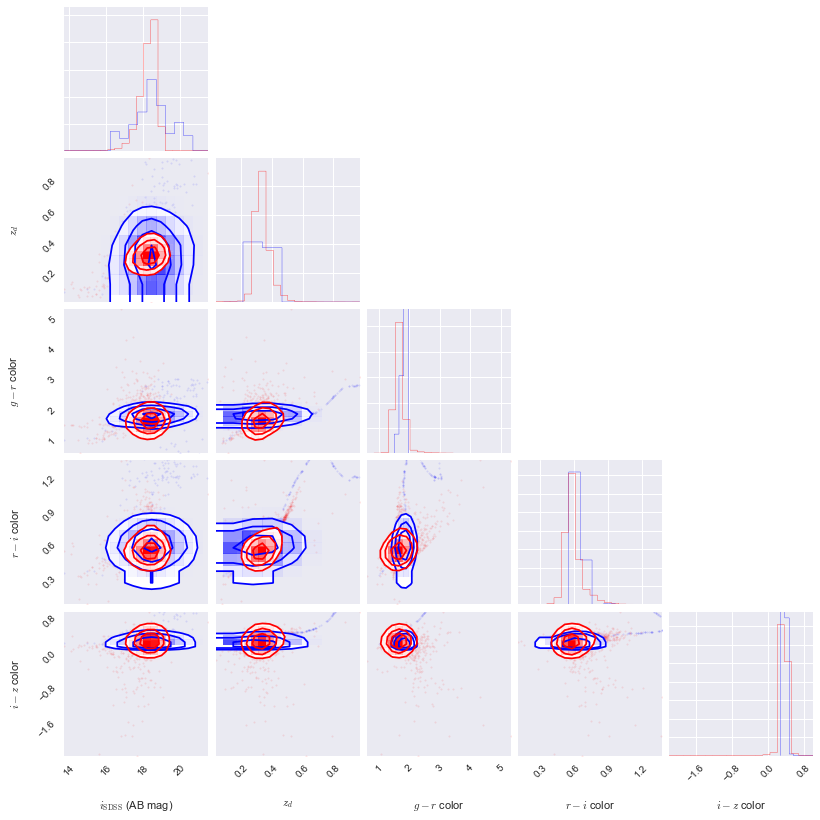

In [6]:
matplotlib.rc('text', usetex=False)

# save the synthetically colored OM10 lenses' cornerplot to fig1
names = ['i_SDSS', 'ZLENS', 'gr', 'ri', 'iz']
om10data = Table({'i_SDSS':db.sample['i_SDSS_lens'], 'ZLENS':db.sample['ZLENS'], 'gr':gr, 'ri':ri, 'iz':iz}, names=names)
om10features, labels = om10.extract_features(om10data, names)
fig1 = corner.corner(om10features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

# overlay fig1 with the real distribution
realdata = Table({'i_SDSS': iReal, 'ZLENS': zReal, 'gr': grReal, 'ri': riReal, 'iz': izReal}, names=names)
realfeatures, labels = plotting.extract_features(realdata, names)
corner.corner(realfeatures, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True), hist2d_kwarge=dict(alpha=0.5))

## Discussion

The synthetic magnitude comparisons between OM10 lens galaxies and similarly massive galaxies found as SDSS LRGs show that the `lenspop` synthetic lens galaxy colors are accurate.

Specifically, the `i` band magnitude mean of 200 selected lenses was `19.25`, and the `i` band magnitude mean standard deviation of the lenses were `1.50`. SDSS LRGs have `i` band magnitude mean of `18.26`, and `i` band magnitude standard deviation of `0.49`.

Using the central limit theorem under the evidence that there are more than 30 data points, we could assume that both OM10 lenses and LRG data are normally distributed. From this assumption, we could calculate the sigma difference.

The difference between two magnitudes are `0.99`, and the sum of standard deviation squared is `2.49`. Thus, the standard deviation would be $2.49^{0.5} = 1.57$. As $\frac{0.99}{1.57} = 0.63$, the two distribution agrees in `0.63` sigma level.

## 2 Comparing the Lens Galaxy Synthetic Photometry with SL2S Lens Galaxies

In two papers, [Sonnenfeld et al (2014)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/97/meta#apj485108t5) and [Sonnenfeld et al (2015)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/98/meta) provide photometric measurements of 56 SL2S galaxy-scale lenses that were taken with Canada-France-Hawaii Telescope (CFHT). We can compare the distributions of magnitude, redshift and color between the OM10 lens galaxies (as painted above) and the SL2S lens galaxies. 

CFHT magnitudes and SDSS magnitudes are different by just $~0.05 mag$; for the sake of simple calculation, we ignore thses small differences in this notebook.

We scraped the lens galaxy photometry and redshifts from the above papers into three datafiles. All the files contain LensName, which we used to match the data of the same lens systems in different datafiles. The second cell below merges all the information needed.

In [7]:
III_a = np.genfromtxt('../data/SonnenfeldTable1.txt', dtype=str, usecols = (0, 4, 5, 6, 7, 8), invalid_raise=False, missing_values='xxx', usemask=False)
III_b = np.genfromtxt('../data/SonnenfeldTable2.txt', dtype=str, usecols = (0, 1), invalid_raise=False, missing_values='xxx')
IV = np.genfromtxt('../data/SonnenfeldTable3.txt', dtype=str, usecols = (0, 11), invalid_raise=False, missing_values='xxx')

/Users/pjm/miniconda2/envs/lsst/lib/python2.7/site-packages/ipykernel/__main__.py:2: ConversionWarning: Some errors were detected !
    Line #7 (got 1 columns instead of 2)
    Line #36 (got 1 columns instead of 2)
    Line #41 (got 1 columns instead of 2)
    Line #45 (got 1 columns instead of 2)
  from ipykernel import kernelapp as app
/Users/pjm/miniconda2/envs/lsst/lib/python2.7/site-packages/ipykernel/__main__.py:3: ConversionWarning: Some errors were detected !
    Line #12 (got 11 columns instead of 2)
    Line #41 (got 11 columns instead of 2)
    Line #49 (got 11 columns instead of 2)
    Line #66 (got 11 columns instead of 2)
    Line #71 (got 11 columns instead of 2)
  app.launch_new_instance()


In [8]:
name = np.array([])
redshiftReal = np.array([])
iReal = np.array([])
grReal = np.array([])
riReal = np.array([])
izReal = np.array([])
for (lensName, aIndex) in zip(III_a[:,0], range(len(III_a))):
    if lensName in III_b[:,0]:
        bIndex = np.argwhere(III_b[:,0]==lensName)[0][0]
        if lensName in IV[:,0]:
            VIndex = np.argwhere(IV[:,0]==lensName)[0][0]
            # the redshift sometimes has some problem, so we should handle those problems
            if(IV[VIndex][1].isdigit()):
                name = np.append(name, lensName)
                redshiftReal = np.append(redshiftReal, float(III_b[bIndex][1]))
                iReal = np.append(iReal, float(III_a[aIndex][4]))
                grReal = np.append(grReal, float(III_a[aIndex][2]) - float(III_a[aIndex][3]))
                riReal = np.append(riReal, float(III_a[aIndex][3]) - float(III_a[aIndex][4]))
                izReal = np.append(izReal, float(III_a[aIndex][4]) - float(III_a[aIndex][5]))
#convert every numpy array to list - if not, OM10.plot_sample throws an error
redshift = np.array(redshiftReal.tolist())
iReal = np.array(iReal.tolist())
grReal = np.array(grReal.tolist())
riReal = np.array(riReal.tolist())
izReal = np.array(izReal.tolist())
from astropy.table import Table
data = Table({'MAGI': iReal, 'ZLENS': redshiftReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['MAGI', 'ZLENS', 'GR', 'RI', 'IZ'])

We only have around 35 real lenses to use to weight the mock lenses. While this is not a large sample, we can still plot the synthetically colored lenses after reweighting the mock lenses to match the real lens redshift distribution. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap.

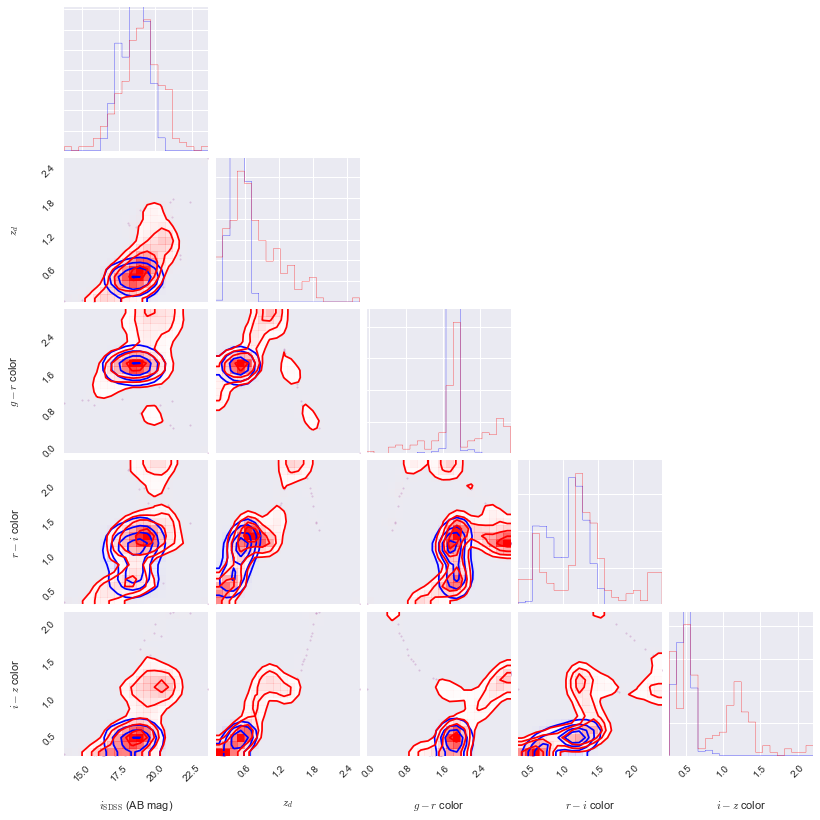

In [9]:
%%capture
db.gaussian_reweight(np.mean(redshift), np.std(redshift))
matplotlib.rc('text', usetex=False)

gr = db.sample['g_SDSS_lens'] - db.sample['r_SDSS_lens']
ri = db.sample['r_SDSS_lens'] - db.sample['i_SDSS_lens']
iz = db.sample['i_SDSS_lens'] - db.sample['z_SDSS_lens']

data = Table({'i_SDSS': db.sample['i_SDSS_lens'], 'ZLENS': db.sample['ZLENS'], 'gr': gr, 'ri': ri, 'iz': iz}, names=names)
features, labels = plotting.extract_features(data, names)
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

features, labels = plotting.extract_features(data, names)
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True))

## Discussion

The synthetic magnitude comparisons between OM10 lens galaxies and similarly massive galaxies found in CFHT data show that the `lenspop` synthetic lens galaxy colors are accurate.

Specifically, the `i` band magnitude mean of 200 selected lenses was `19.25`, and the `i` band magnitude mean standard deviation of the lenses were `1.50`. CFHT data have `i` band magnitude mean of `19.11`, and `i` band magnitude standard deviation of `0.87`.

Using the central limit theorem under the evidence that there are more than 30 data points, we could assume that both OM10 lenses and CFHT data are normally distributed. From this assumption, we could calculate the sigma difference.

The difference between two magnitudes are `0.14`, and the sum of standard deviation squared(variance) is `3.00`. Thus, the standard deviation would be $3.00^{0.5} = 1.73$. As $\frac{0.14}{1.73} = 0.08$, the two distribution agrees in `0.08` sigma level.

## 3 Comparing the Lensed Quasar Synthetic Photometry with SDSS Quasars

The last comparison that we make is with the lensed sources. [This file](https://raw.githubusercontent.com/KIPAC/StatisticalMethods/master/examples/SDSScatalog/data/qso10000.csv) contains magnitudes and redshifts for 10,000 SDSS quasars. We will compare the synthetically colored OM10 lensed quasars with this data. The processes are the same as the above.

In [10]:
# Read the data
pd.set_option('display.max_columns', None)
qsos = pd.read_csv("https://raw.githubusercontent.com/KIPAC/StatisticalMethods/master/examples/SDSScatalog/data/qso10000.csv",index_col=0)
# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10) & (qsos["mag_i"]<23.6)]
qso = qsos.as_matrix()

matplotlib.rc('text', usetex=False)
zReal = qsos["spec_z"].as_matrix()
iReal = qsos["mag_i"].as_matrix()
grReal = qsos["g_r_color"].as_matrix()
riReal = qsos["r_i_color"].as_matrix()
izReal = qsos["i_z_color"].as_matrix()

db.gaussian_reweight(np.mean(zReal), np.std(zReal))

There is the lack of scatter in the synthetic quasar colors in OM10 compared to the real data, so we could add the noise by doing the following:

In [11]:
db.noissify_quasars(np.std(iReal))

In [12]:
%%capture
gr = db.sample['g_SDSS_quasar'] - db.sample['r_SDSS_quasar']
ri = db.sample['r_SDSS_quasar'] - db.sample['i_SDSS_quasar']
iz = db.sample['i_SDSS_quasar'] - db.sample['z_SDSS_quasar']

names = ['i_SDSS','ZSRC', 'gr', 'ri', 'iz']

data = Table({'i_SDSS': db.sample['i_SDSS_quasar'], 'ZSRC': db.sample['ZSRC'], 'gr': gr, 'ri': ri, 'iz': iz}, names=names)
features, labels = plotting.extract_features(data, names)
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

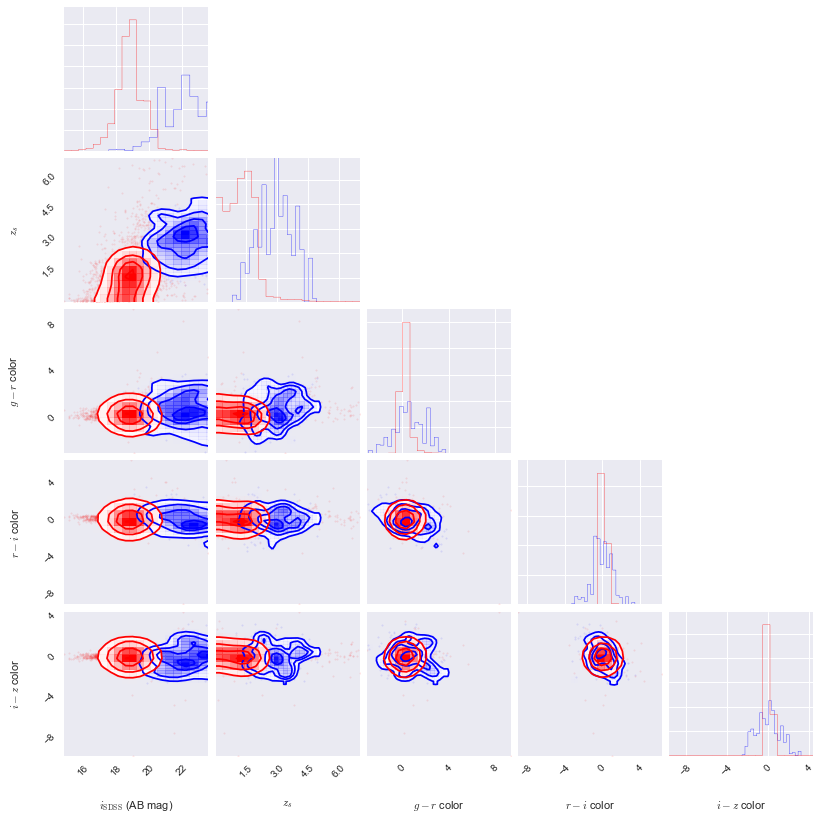

In [13]:
matplotlib.rc('text', usetex=False)
data = Table({'i_SDSS': iReal, 'ZSRC': zReal, 'gr': grReal, 'ri': riReal, 'iz': izReal}, names=names)
features, labels = plotting.extract_features(data, names)
corner.corner(features, labels=labels, color='red', smooth=1.3, hist_kwargs=dict(normed=True), fig=fig1)

## Discussion

The synthetic magnitude comparisons between OM10 quasars and similarly bright quasars found as SDSS QSOs show that the `lenspop` synthetic lens quasar colors are accurate.

The mean `i` band magnitude of 200 selected quasars was `22.18`, and the standard deviation of the lenses were `1.36`. SDSS Quasars have `i` band magnitude mean of `18.85`, and `i` band magnitude standard deviation of `0.83`.

Using the central limit theorem under the evidence that there are many data points, we could assume that both the data points of OM10 quasars and SRGs are normally distributed. From this assumption, we could calculate the sigma difference.

The difference between two magnitudes are `3.68`, and the sum of standard deviation squared(variance) is `2.54`. Thus, the standard deviation would be $2.54^{0.5} = 1.59$. As $\frac{3.68}{1.59} = 2.31$, the two distribution agrees in `2.31` sigma level.

This suggests that quasars show some differences between the synthetically colored magnitudes and the real magnitudes. The difference seems to arise from the selection effect present in the SDSS objects: the sample of SDSS LRGs shows a cut in the $u$-band magnitude, which in turn truncates the distribution of `i` band magnitudes.

Still, the color index was reliable. Synthetically colored OM10 quasars had mean `g-r` magnitude of `0.33`, and standard deviation of `1.65`. SDSS QSOs had mean `g-r` magnitudes of `0.24`, and standard deviation of `g-r` magnitudes of `0.37`. The difference is far less than one sigma level.

## Summary

Overall, in this notebook we have show that the synthetic magnitude coloring algorithm in OM10 `paint` method deviates at most at the one sigma level for the lens galaxies. For quasars, there was a selection effect present in the SDSS objects, which was a source of the differences. However, the color index of synthetically colored quasars matched well with the real data.